## Installing Required Libraries
This cell installs the necessary Python libraries for the project.


In [2]:
!pip install torchsummary
!pip install torchinfo
!pip install torch_optimizer
!pip install torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.4 MB/s eta 0:00:00


## Importing all the required libraries

In [3]:
import torch
import pickle
import numpy as np
import pandas as pd 
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
from torchinfo import summary
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch_optimizer as optim2
from torchsummary import summary
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler
from torchvision.transforms import AutoAugmentPolicy
from torch.optim.lr_scheduler import CosineAnnealingLR

## Data Transformations and Loaders
The following code configures data augmentation and normalization for training and testing datasets. It loads the CIFAR-10 training and test batches from pickle files, creates datasets using the CIFARDataset class, and sets up DataLoader objects for efficient batch processing.

In [4]:
class CIFARDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):

        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]

        # 1) If shape is (3072,) => reshape to (3,32,32)
        if x.shape[0] == 3072 and x.ndim == 1:
            x = x.reshape(3, 32, 32)

        # 2) If shape is (32,32,3) => transpose to (3,32,32)
        elif x.shape == (32, 32, 3):
            x = np.transpose(x, (2, 0, 1))

        # Convert to a PIL image for torchvision transforms
        # x is [3, H, W], so we convert to [H, W, 3] first
        x = np.transpose(x, (1, 2, 0))  # shape => (32, 32, 3)
        img = Image.fromarray(x.astype(np.uint8))

        if self.transform:
            img = self.transform(img)
        if self.labels is not None:
            label = self.labels[idx]
            return img, label
        else:
            return img


In [5]:
# Data transform
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(AutoAugmentPolicy.CIFAR10),  # Automated augmentation policy
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.2023, 0.1994, 0.2010]),

    transforms.RandomErasing(p=0.5),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4942, 0.4851, 0.4504], std=[0.2020, 0.1991, 0.2011]),
])

train_files = [
    '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1',
    '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_2',
    '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_3',
    '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_4',
    '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_5'
]

test_file = '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch'

all_data = []
all_labels = []
for a in train_files:
    with open(a, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    all_data.append(batch[b'data'])      # shape => (10000, 3072) each
    all_labels.extend(batch[b'labels'])  # 10000 labels

train_data = np.vstack(all_data)          # (50000, 3072)
train_labels = np.array(all_labels)       # (50000,)

# Train dataset
train_dataset = CIFARDataset(data=train_data,
                             labels=train_labels,
                             transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

with open(test_file, 'rb') as f:
    batch = pickle.load(f, encoding='bytes')
test_data = np.array(batch[b'data'])   # (10000, 3072)
test_labels = np.array(batch[b'labels'])

test_dataset = CIFARDataset(data=test_data,
                            labels=test_labels,
                            transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)


## Model 
This cell implements a modified ResNet architecture, incorporating Squeeze-and-Excitation (SE) blocks. It defines helper functions (conv1x1), the SEBlock for channel-wise attention, the BasicBlock with dropout and SE, and the full ModifiedResNet model with a custom layer configuration.


In [6]:
def conv1x1(in_channels, out_channels, stride=1, groups=1, bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, groups=groups, bias=bias)

# Convolution-based SE Block (using 1x1 convolutions)
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super(SEBlock, self).__init__()
        mid_channels = channels // reduction
        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv1 = conv1x1(in_channels=channels, out_channels=mid_channels, bias=True)
        self.activ = nn.ReLU(inplace=True)
        self.conv2 = conv1x1(in_channels=mid_channels, out_channels=channels, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        w = self.pool(x)
        w = self.conv1(w)
        w = self.activ(w)
        w = self.conv2(w)
        w = self.sigmoid(w)
        return x * w

# BasicBlock with SE 
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, reduction=8, dropout_rate=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)

        # Use the convolution-based SE Block
        self.se    = SEBlock(planes, reduction=reduction)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

        self.dropout = nn.Dropout(p=dropout_rate) if dropout_rate > 0.0 else nn.Identity()

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out = self.se(out)   # Apply SE
        out += self.shortcut(x)
        out = F.relu(out, inplace=True)
        return out

# 4. Modified ResNet for CIFAR-10 with [4, 4, 4, 3] residual blocks
class ModifiedResNet(nn.Module):
    def __init__(self, num_classes=10, reduction=8):
        super(ModifiedResNet, self).__init__()
        self.in_planes = 32

        # Stem: from 3 channels to 32 channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(32)

        self.layer1 = self._make_layer(BasicBlock, 32, num_blocks=4, stride=1,
                                       reduction=reduction, dropout_rate=0.0)
        self.layer2 = self._make_layer(BasicBlock, 64, num_blocks=4, stride=1,
                                       reduction=reduction, dropout_rate=0.2)
        self.layer3 = self._make_layer(BasicBlock, 128, num_blocks=4, stride=2,
                                       reduction=reduction, dropout_rate=0.3)
        self.layer4 = self._make_layer(BasicBlock, 256, num_blocks=3, stride=2,
                                       reduction=reduction, dropout_rate=0.3)

        # Global average pooling and final classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, reduction, dropout_rate):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s, reduction=reduction, dropout_rate=dropout_rate))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

def BuildModifiedResNet():
    return ModifiedResNet(num_classes=10, reduction=8)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = BuildModifiedResNet().to(device)

# Model params
summary(model, input_size=(3, 32, 32))


Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
          Identity-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           9,216
       BatchNorm2d-7           [-1, 32, 32, 32]              64
 AdaptiveAvgPool2d-8             [-1, 32, 1, 1]               0
            Conv2d-9              [-1, 4, 1, 1]             132
             ReLU-10              [-1, 4, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]             160
          Sigmoid-12             [-1, 32, 1, 1]               0
          SEBlock-13           [-1, 32, 32, 32]               0
       BasicBlock-14

# Model Training

In [15]:
# Mixed Precision Scaler for AMP
scaler = amp.GradScaler()

criterion = CrossEntropyLoss(label_smoothing=0.1)
base_optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
optimizer = optim2.Lookahead(base_optimizer, k=5, alpha=0.5)

num_epochs = 175
steps_per_epoch = len(train_loader)

scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

train_losses = []
test_losses = []
test_accuracies = []

# Early stopping 
best_accuracy = 0.0
patience = 10  
patience_counter = 0
min_delta = 0.01

# Mixup augmentation for regularization
use_mixup = True

def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    index = torch.randperm(x.size(0)).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    # Mixup loss
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

#  Training 
for epoch in range(1, num_epochs + 1):
    model.train()
    running_train_loss = 0.0

    for step, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        if use_mixup:
            images, y_a, y_b, lam = mixup_data(images, labels, alpha=0.2)
        
        with autocast(enabled=True):
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam) if use_mixup else criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Gradient clipping

        scaler.step(optimizer)
        scaler.update()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation 
    model.eval()
    running_test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracy = 100.0 * correct / total
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch}/{num_epochs}] - "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}"
          f"Train Loss: {avg_train_loss:.4f} - "
          f"Test Loss: {avg_test_loss:.4f} - "
          f"Test Accuracy: {test_accuracy:.2f}%")

    scheduler.step()

    #  Early Stopping
    improvement = test_accuracy - best_accuracy
    if abs(improvement) > min_delta:
        best_accuracy = test_accuracy
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.optimizer.state_dict(),  # Lookahead stores base_optimizer
            'train_losses': train_losses,
            'test_losses': test_losses,
            'test_accuracies': test_accuracies,
        }, 'modifiedResnet_cifar10.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered! No significant improvement for {patience} epochs.")
            break

print("✅ Model saved as 'modifiedResnet_cifar10.pth'")


<ipython-input-15-ea232d17d7b4>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
<ipython-input-15-ea232d17d7b4>:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Epoch [1/175] - LR: 0.100000Train Loss: 2.0304 - Test Loss: 1.5336 - Test Accuracy: 52.52%
Epoch [2/175] - LR: 0.099992Train Loss: 1.7825 - Test Loss: 1.4096 - Test Accuracy: 58.81%
Epoch [3/175] - LR: 0.099968Train Loss: 1.6724 - Test Loss: 1.3557 - Test Accuracy: 62.37%
Epoch [4/175] - LR: 0.099928Train Loss: 1.5780 - Test Loss: 1.6288 - Test Accuracy: 50.07%
Epoch [5/175] - LR: 0.099871Train Loss: 1.5314 - Test Loss: 1.4679 - Test Accuracy: 58.40%
Epoch [6/175] - LR: 0.099799Train Loss: 1.4942 - Test Loss: 1.0703 - Test Accuracy: 75.20%
Epoch [7/175] - LR: 0.099710Train Loss: 1.4553 - Test Loss: 1.0513 - Test Accuracy: 76.92%
Epoch [8/175] - LR: 0.099606Train Loss: 1.4242 - Test Loss: 1.1548 - Test Accuracy: 71.19%
Epoch [9/175] - LR: 0.099485Train Loss: 1.4099 - Test Loss: 1.5166 - Test Accuracy: 58.04%
Epoch [10/175] - LR: 0.099349Train Loss: 1.3893 - Test Loss: 1.2983 - Test Accuracy: 66.09%
Epoch [11/175] - LR: 0.099196Train Loss: 1.3894 - Test Loss: 0.9640 - Test Accuracy: 80.6

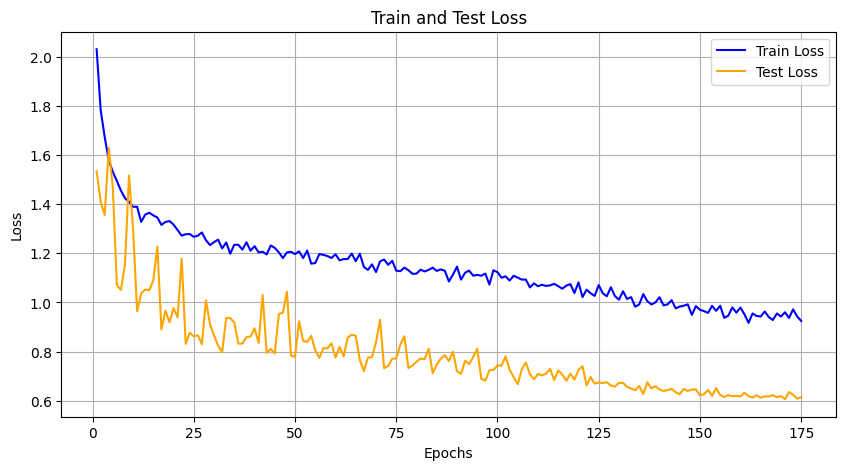

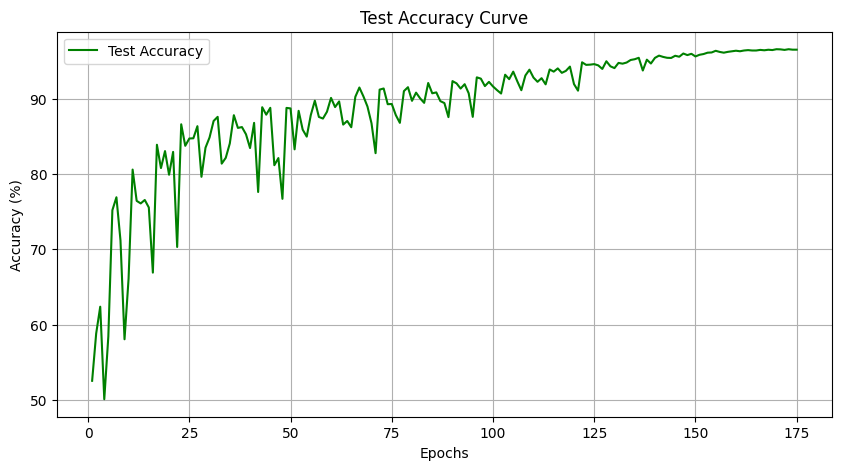

In [16]:
# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss", color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.grid()
plt.savefig('modifiedResnet_cifar10_loss_curve.png')
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve')
plt.legend()
plt.grid()
plt.savefig('modifiedResnet_cifar10_accuracy_curve.png')
plt.show()


## Test on kaggle test dataset
The following code performs inference on the Kaggle test data, and applies Test-Time Augmentation (TTA) by averaging predictions from original and horizontally flipped images to improve generalization.

In [17]:
kaggle_file = '/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl'
with open(kaggle_file, 'rb') as f:
    content = pickle.load(f, encoding='bytes')
kaggle_data = content[b'data']
kaggle_data = np.array(kaggle_data)

kaggle_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5121, 0.4964, 0.4612], std=[0.2115, 0.2103, 0.2119]),
])



kaggle_dataset = CIFARDataset(data=kaggle_data,
                              labels=None,  
                              transform=kaggle_test_transform)
kaggle_loader = DataLoader(kaggle_dataset, batch_size=128, shuffle=False, num_workers=2)

In [18]:
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

all_predictions = []

with torch.no_grad():
    for images in kaggle_loader:
        images = images.to(device)
        preds = []
        
        outputs = model(images)
        preds.append(outputs)
        # TTA: Horizontal flip predictions
        outputs_flip = model(torch.flip(images, dims=[3]))
        preds.append(outputs_flip)
        
        # Average predictions across TTA variants
        avg_preds = torch.stack(preds).mean(dim=0)
        _, pred_labels = avg_preds.max(1)
        all_predictions.extend(pred_labels.cpu().numpy())


In [19]:
submission = pd.DataFrame({
    'ID': list(range(len(all_predictions))),
    'Labels': all_predictions
})

submission.to_csv('submission.csv', index=False)